Todo: 
* Show data before and after scaling
* Update comments
* Random quality checks
* Fix elevation

# Cloudy With a Chance of Football
## Global Machine Learning Model (Incomplete)
<a id='header_cell'></a>
Author: Aidan O'Connor   
Date: 1 June 2021   

### Table of Contents:
- [Data Preparation](#import_and_options_cell)
    - [Import packages, read in data, set options](#import_and_options_cell)
    - [Understanding the data](#data_review_cell)
    - [Preparing the data](#scoring_models_cell)
- [Global Machine Learning Model](#global_model_cell)
    - [Model Selection](#model_selection_cell)
        - [Selecting Columns](#column_selection_cell)
        - [Selecting models to score](#model_scoring_selection_cell)
        - [Scoring selected models](#scoring_models_cell)
    - [Hyperparameter Tuning](#hyperparameter_tuning_cell)

## Data Preparation
<a id='data_prep_section_cell'></a>

### Import packages, read in data, set options
<a id='import_and_options_cell'></a>
I'll start by importing all necessary packages to import, manipulate, visualize, and create machine learning models for data.   

Then, I'll set some preferences for some of these packages.   

Finally, I'll access our sqlite3 database and bring in a series of dataframes from the tables, then merge them. I chose not to do this with a single SQL statement, since I tried this with some difficulty

In [1]:
# Packages to import and manipulate data
import sqlite3
import pandas as pd
import numpy as np

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Packages to create and visualize machine learning models from yellowbrick
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import confusion_matrix

# Packages to create machine learning models from scikit-learn
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

In [2]:
# Set pandas viewing options
pd.set_option('display.max_columns', None)

# Bring in jupyter magic
%matplotlib inline

# Set matplotlib visualization styling options
plt.rcParams['figure.figsize'] = (18,7)
plt.style.use('fivethirtyeight')

In [3]:
# Read in all data from database and merge the data on player_id
conn = sqlite3.connect('../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

In [4]:
cursorObj.execute("select * from SQLite_master")

tables = cursorObj.fetchall()

print("Here are the tables and indices from the main database:")
for table in tables:
        print(f"Type of database object: {table[0]}")
        print(f"Name of the database object: {table[1]}")
        print(f"Table Name: {table[2]}")
        print(f"Root page: {table[3]}")
        print(f"SQL statement: {table[4]}")

Here are the tables and indices from the main database:
Type of database object: table
Name of the database object: positions
Table Name: positions
Root page: 2
SQL statement: CREATE TABLE "positions" (
"PlayerID" INTEGER,
  "Position" TEXT
)
Type of database object: table
Name of the database object: player_dob
Table Name: player_dob
Root page: 125
SQL statement: CREATE TABLE "player_dob" (
"PlayerID" INTEGER,
  "dob" TEXT
)
Type of database object: table
Name of the database object: players
Table Name: players
Root page: 154
SQL statement: CREATE TABLE "players" (
"PlayerID" INTEGER,
  "FirstName" TEXT,
  "LastName" TEXT,
  "uniqueID" TEXT
)
Type of database object: table
Name of the database object: player_team
Table Name: player_team
Root page: 190
SQL statement: CREATE TABLE "player_team" (
"PlayerID" INTEGER,
  "week_id" TEXT,
  "Team" TEXT
)
Type of database object: table
Name of the database object: player_age
Table Name: player_age
Root page: 393
SQL statement: CREATE TABLE "p

In [5]:
birthday = pd.read_sql_query('SELECT * from player_dob', conn)

positions = pd.read_sql_query('SELECT * from positions',conn)

player_team = pd.read_sql_query('SELECT * from player_team',conn)

player_age = pd.read_sql_query('SELECT * from player_age',conn)

injury_status = pd.read_sql_query('SELECT * from injury_status',conn)

days_since_last_game = pd.read_sql_query('SELECT * from days_since_last_game',conn)

weather = pd.read_sql_query('SELECT * from weather',conn)

hours_displaced = pd.read_sql_query("""
                                    SELECT week_id,
                                    team_away_short,
                                    team_home_short,
                                    absolute_hours_displaced 
                                    from hours_displaced
                                    """,
                                    conn)
target = pd.read_sql_query("""
                            SELECT week_id,
                            PlayerID,
                            performance,
                            performance_class
                            from performance_target
                            """,
                            conn)

elevation = pd.read_sql_query("""
                              SELECT Team,
                              elevation
                              from elevation_and_conference
                              """,
                              conn)

stats = pd.read_sql_query("""
                          SELECT PlayerID,
                          SeasonType,
                          Season,
                          GameDate,
                          Week,
                          Team,
                          PositionCategory,
                          Played,
                          Started,
                          PassingAttempts,
                          PassingCompletions,
                          PassingYards,
                          PassingCompletionPercentage,
                          PassingYardsPerAttempt,
                          PassingYardsPerCompletion,
                          PassingTouchdowns,
                          PassingInterceptions,
                          PassingRating,
                          PassingLong,
                          PassingSacks,
                          PassingSackYards,
                          RushingAttempts,
                          RushingYards,
                          RushingYardsPerAttempt,
                          RushingTouchdowns,
                          RushingLong,
                          ReceivingTargets,
                          Receptions,
                          ReceivingYards,
                          ReceivingYardsPerReception,
                          ReceivingTouchdowns,
                          ReceivingLong,
                          Fumbles,
                          FumblesLost,
                          PuntReturns,
                          PuntReturnYards,
                          PuntReturnTouchdowns,
                          KickReturns,
                          KickReturnYards,
                          KickReturnTouchdowns,
                          SoloTackles,
                          AssistedTackles,
                          TacklesForLoss,
                          Sacks,
                          SackYards,
                          QuarterbackHits,
                          PassesDefended,
                          FumblesForced,
                          FumblesRecovered,
                          FumbleReturnTouchdowns,
                          Interceptions,
                          InterceptionReturnTouchdowns,
                          FieldGoalsAttempted,
                          FieldGoalsMade,
                          ExtraPointsMade,
                          TwoPointConversionPasses,
                          TwoPointConversionRuns,
                          TwoPointConversionReceptions,
                          ExtraPointsAttempted,
                          FieldGoalsMade0to19,
                          FieldGoalsMade20to29,
                          FieldGoalsMade30to39,
                          FieldGoalsMade40to49,
                          FieldGoalsMade50Plus,
                          week_id,
                          HomeOrAway,
                          Opponent
                          from stats_regular
                          """,
                          conn)

redzone = pd.read_sql_query("""
                            SELECT PlayerID,
                            OpponentRZ,
                            PassingYardsRZ,
                            PassingTouchdownsRZ,
                            PassingInterceptionsRZ,
                            RushingYardsRZ,
                            RushingTouchdownsRZ,
                            ReceptionsRZ,
                            ReceivingYardsRZ,
                            ReceivingTouchdownsRZ,
                            SacksRZ,
                            InterceptionsRZ,
                            FumblesForcedRZ,
                            FumlbesRecoveredRZ,
                            FantasyPointsRZ,
                            Season,
                            week_id
                            from redzone_stats
                            """,
                            conn)

defense = pd.read_sql_query("""
                            SELECT PointsAllowed,
                            Team,
                            TouchdownsScored,
                            Sacks,
                            SackYards,
                            FumblesForced,
                            FumblesRecovered,
                            FumbleReturnTouchdowns,
                            Interceptions,
                            InterceptionReturnTouchdowns,
                            BlockedKicks,
                            Safeties,
                            PuntReturnTouchdowns,
                            KickReturnTouchdowns,
                            BlockedKickReturnTouchdowns,
                            FieldGoalReturnTouchdowns,
                            QuarterbackHits,
                            TacklesForLoss,
                            DefensiveTouchdowns,
                            SpecialTeamsTouchdowns,
                            PointsAllowedByDefenseSpecialTeams,
                            TwoPointConversionReturns,
                            PlayerID,
                            week_id
                            from defense_stats
                            """,
                            conn)

In [6]:
frames = [
    positions,
    player_team,
    player_age,
    injury_status,
    days_since_last_game,
    weather,
    hours_displaced,
    target,
    elevation,
    stats,
    redzone,
    defense
]

In [7]:
names = [
    'positions',
    'player_team',
    'player_age',
    'injury_status',
    'days_since_last_game',
    'weather',
    'hours_displaced',
    'target',
    'elevation',
    'stats',
    'redzone',
    'defense'
]

player_age
injury_status
target
stats


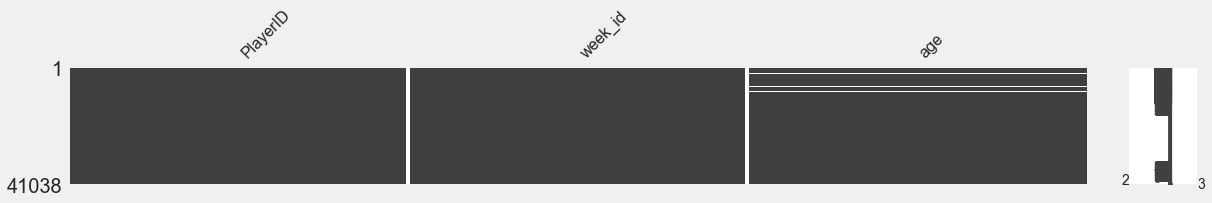

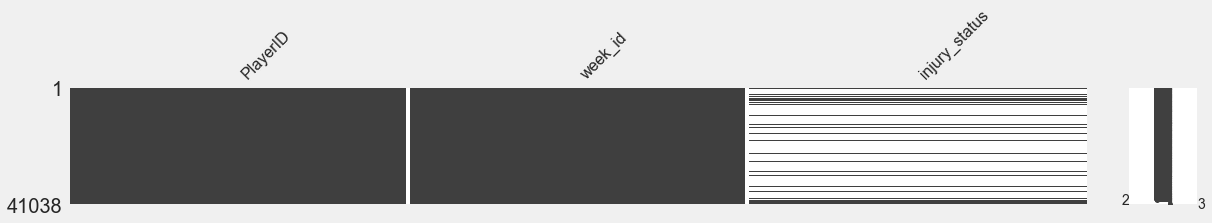

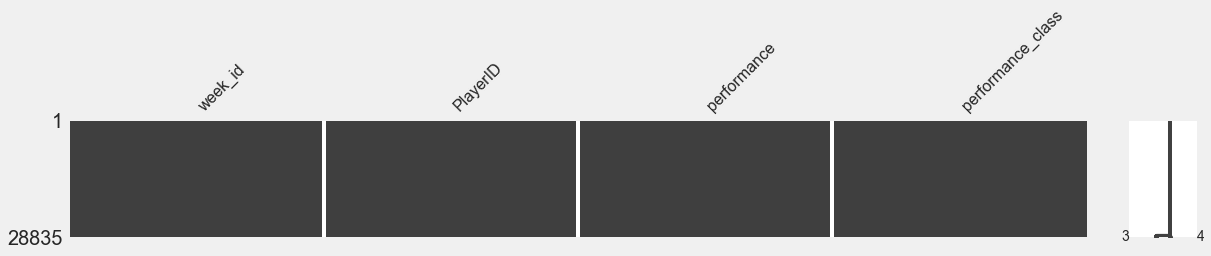

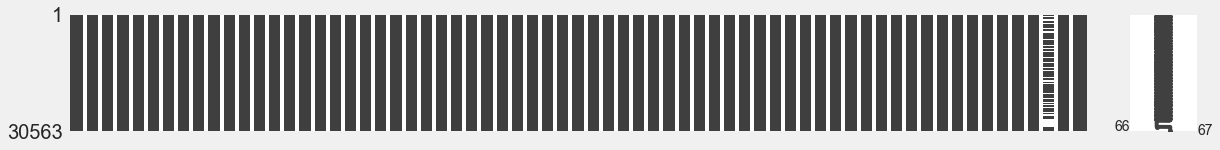

In [8]:
for n,x in zip(frames,names):
    if n.isnull().sum().sum() > 0:
        msno.matrix(n, figsize=(18, 2))
        print(x)
    else:
        pass

## Merging Datasets to Make a Dataframe
### 1. ```Stats``` Dataframe
First, I'll read in the ```fantasyPlayerScores.csv```, ```fantasyKickerScores.csv```, ```redzone```, and ```fantasyDefenseScores.csv``` to make a collective dataframe with all stats available. I'll also filter out all of the 2018 stats

In [120]:
# Read in dataframes, then drop select columns and filter select rows

# Player stats
df = pd.read_csv('../../fixtures/cleaned_data/fantasyPlayerScores.csv')
df = df[df['Season'] != 2018]
df = df.drop([
    'Name',
    'Number',
    'GameDate',
    'PlayerGameID',
    'FantasyPosition',
    'FantasyPointsDraftKings',
    'FantasyPointsFanDuel',
    'FantasyPoints',
    'FantasyPointsPPR',
    'SeasonType'
], axis = 'columns')

# Defense stats
defense = pd.read_csv('../../fixtures/cleaned_data/fantasyDefenseScores.csv')
defense = defense[defense['Season'] != 2018]
defense = defense.drop([
    'FantasyPointsFanDuel',
    'FantasyPointsDraftKings',
    'SeasonType',
    'Date',
    'FantasyPoints'
], axis = 'columns')

# Redzone stats
redzone = pd.read_csv('../../fixtures/cleaned_data/red_zone_stats.csv')
redzone = redzone[redzone['Season'] != 2018]
redzone = redzone.drop([
    'Name',
    'FantasyPointsRZ'
], axis = 'columns')

# Kicker stats
kickers = pd.read_csv('../../fixtures/cleaned_data/fantasyKickerScores.csv')
kickers = kickers[kickers['Season'] != 2018]
kickers = kickers.drop([
    'Unnamed: 0',
    'SeasonType',
    'GameDate',
    'Number',
    'Name',
    'FantasyPoints',
    'FantasyPointsPPR',
    'FantasyPosition',
    'FantasyPointsFanDuel',
    'FantasyPointsDraftKings'
], axis = 'columns')

#### Prepare each dataframe for merging into a bigger dataframe

In [121]:
defense['Position'] = 'DEF'
defense['PositionCategory'] = 'DEF'
defense['Started'] = 1
defense['Played'] = 1

add_these_to_defense = [item for item in list(df) if item not in list(defense)]

for n in add_these_to_defense:
    defense[n] = 0

In [122]:
add_these_to_df = list(set(list(defense)) - set(list(df)))

for n in add_these_to_df:
    df[n] = 0

In [123]:
df = pd.concat([df,defense], ignore_index = True)

In [124]:
kickers['week_id'] = kickers['Season'].astype(str) + "_" + kickers['Week'].astype(str)

add_these_to_kickers = [item for item in list(df) if item not in list(kickers)]

for n in add_these_to_kickers:
    kickers[n] = 0

In [125]:
df = pd.concat([df,kickers], ignore_index = True)

Now I have all player stats, defense stats, and kicker stats in one dataframe, I'm going to remove the individual defensive players from the shared dataframe, then bring in the redzone stats.

In [126]:
df = df[df['Position'].isin(['WR','QB','RB','TE','DEF','K'])]

In [127]:
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PlayerGameID
0,201910115,16003,2019,1,KC,JAX,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,9.0,198.0,22.0,3.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,16,15,16990,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,201910119,19781,2019,1,BAL,MIA,AWAY,QB,OFF,1,1,20.0,17.0,324.0,85.0,16.2,19.1,5.0,0.0,158.33,83.0,1.0,1.0,3.0,6.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3,19,16985,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,201910129,19562,2019,1,LAC,IND,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,12.0,58.0,4.8,1.0,19.0,7.0,6.0,96.0,16.0,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29,14,16991,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,201910109,18055,2019,1,DAL,NYG,HOME,QB,OFF,1,1,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9,23,16993,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,201910105,18877,2019,1,CAR,LAR,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5,32,16989,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29866,202011708,16191,2020,17,PIT,CLE,AWAY,K,ST,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Out,28,8,17506,2020_17,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,990577384.0
29867,202011716,17118,2020,17,LAC,KC,AWAY,K,ST,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29,1

In [128]:
df = pd.merge(df,
              redzone.drop([
                  'Season',
                  'Week',
                  'Team',
                  'Position'
              ], axis = 'columns'),
              how = 'left',
              left_on = ['PlayerID','week_id'],
              right_on = ['PlayerID','week_id'])
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PlayerGameID,OpponentRZ,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ
0,201910115,16003,2019,1,KC,JAX,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,9.0,198.0,22.0,3.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,16,15,16990,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,JAX,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
1,201910119,19781,2019,1,BAL,MIA,AWAY,QB,OFF,1,1,20.0,17.0,324.0,85.0,16.2,19.1,5.0,0.0,158.33,83.0,1.0,1.0,3.0,6.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3,19,16985,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,MIA,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201910129,19562,2019,1,LAC,IND,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,12.0,58.0,4.8,1.0,19.0,7.0,6.0,96.0,16.0,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,29,14,16991,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,IND,0.0,0.0,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,201910109,18055,2019,1,DAL,NYG,HOME,QB,OFF,1,1,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9,23,16993,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NYG,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201910105,18877,2019,1,CAR,LAR,HOME,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5,32,16989,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,LAR,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19283,202011708,16191,2020,17,PIT,CLE,AWAY,K,ST,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,

<AxesSubplot:>

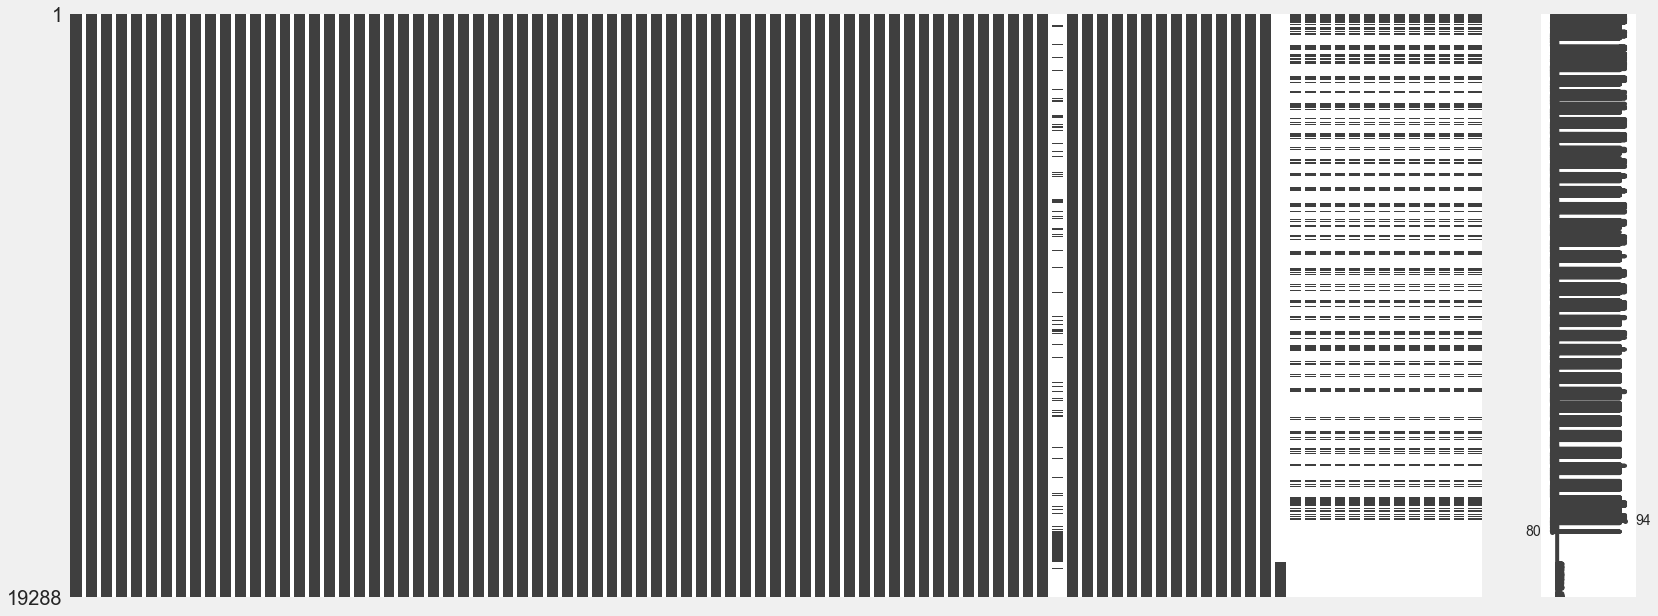

In [129]:
msno.matrix(df)

<AxesSubplot:>

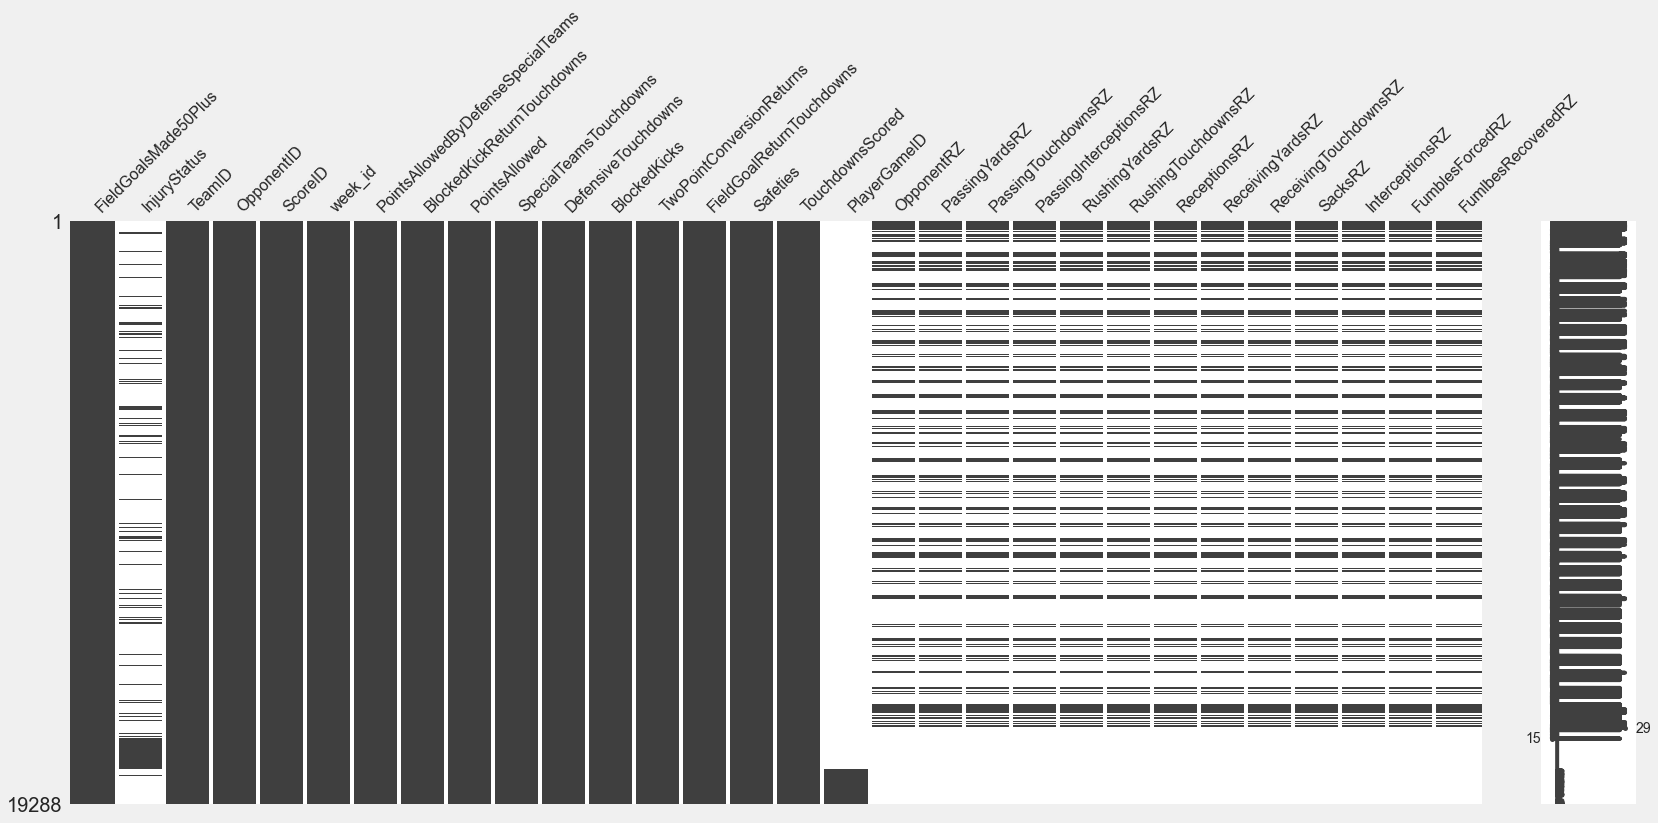

In [130]:
msno.matrix(df[list(df)[-30:]])

In [131]:
# Fill in InjuryStatus nulls
df['InjuryStatus'] = df['InjuryStatus'].apply(
    lambda x: 1 if x == "Questionable" else 0
)

# Drop PlayerGameID
df = df.drop(['PlayerGameID'], axis = 'columns')

# Fill nulls -- since there are only redzone nulls now -- with zero
df = df.fillna(0)

<AxesSubplot:>

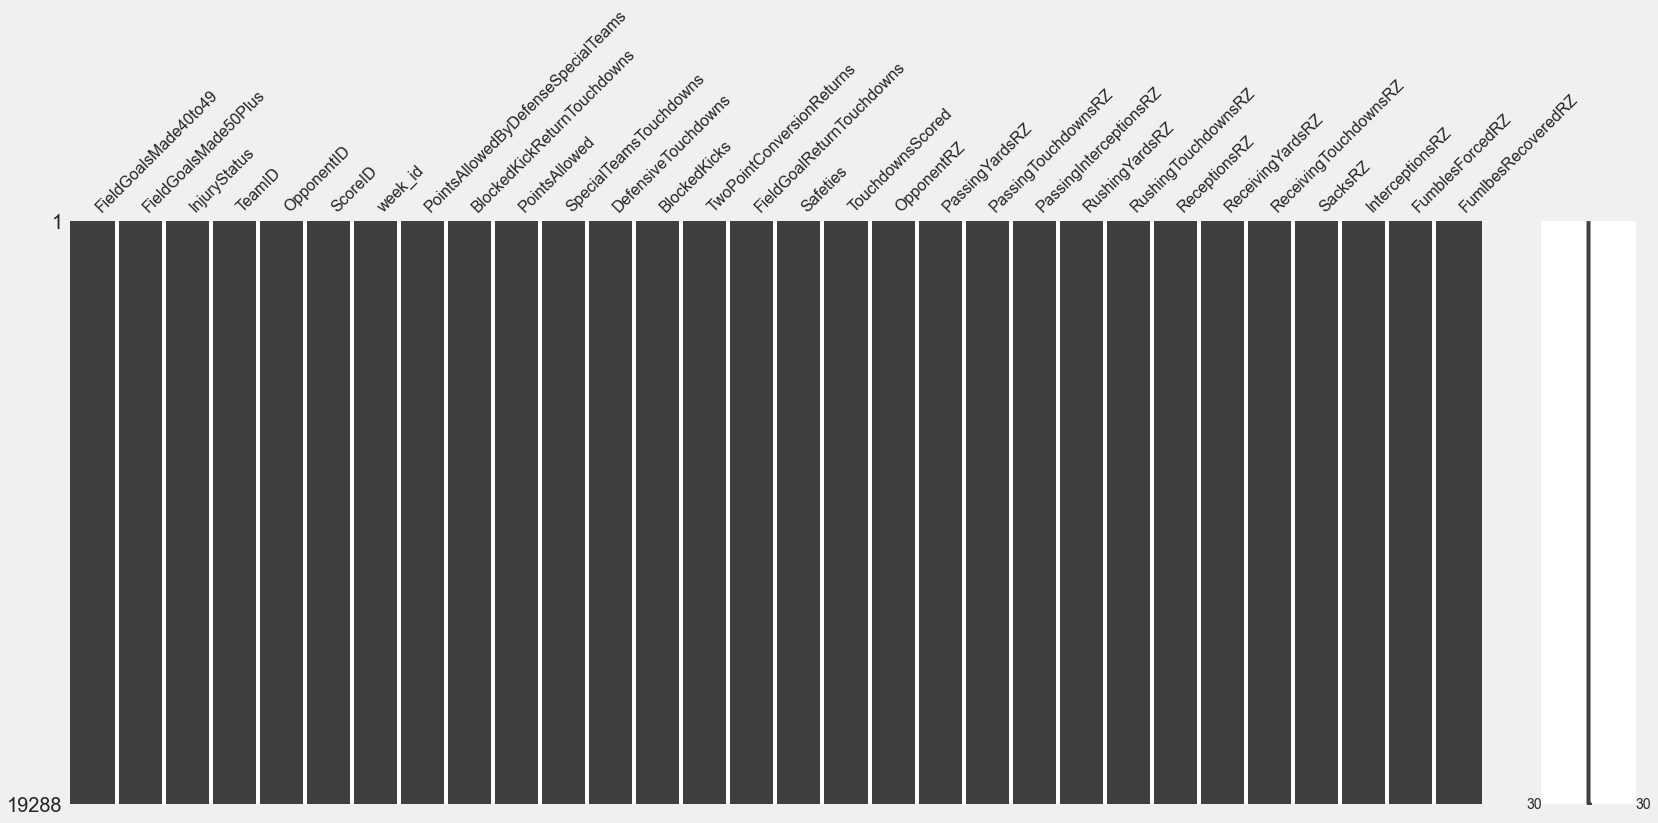

In [132]:
msno.matrix(df[list(df)[-30:]])

### 2. ```days_since_last_game``` Dataframe
Next, I'll merge in the ```days_since_last_game```dataframe. I know there are missing values in this one, so I'll fill them right away.

<AxesSubplot:>

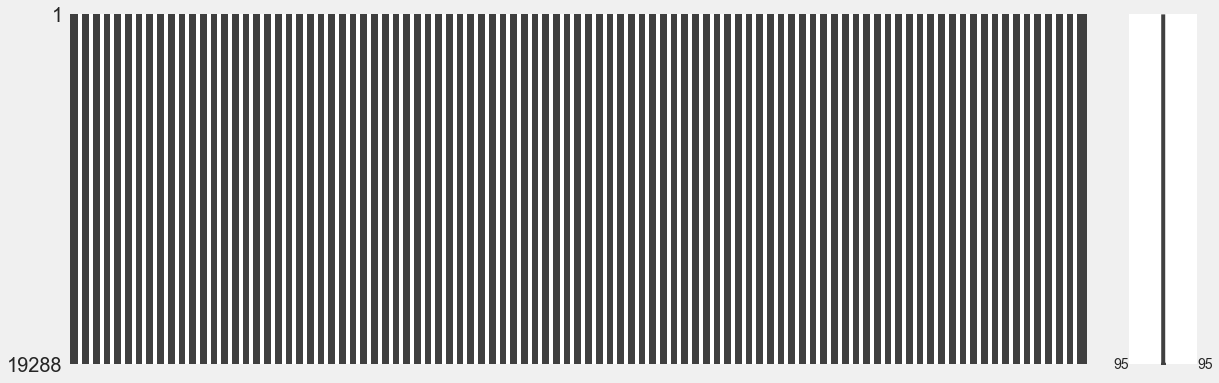

In [133]:
defense_abbrev_dict = {
    'ARI' : 'ARZ',
    'BAL' : 'BLT',
    'CLE' : 'CLV',
    'HOU' : 'HST'
}

df = df.replace({'Team': defense_abbrev_dict, 'Opponent' : defense_abbrev_dict})

df = pd.merge(df,
              days_since_last_game.replace({'Team':defense_abbrev_dict}),
              how = 'left',
              left_on = ['Team','week_id'],
              right_on = ['Team','week_id']
)

msno.matrix(df, figsize=(18,6))

### 3. ```hours_displaced``` Dataframe
I need to split the dataframe into a home and an away dataframe to facilitate merging new data that is predicated on home or away status

In [134]:
home = df[df['HomeOrAway'] == 'HOME']
away = df[df['HomeOrAway'] == 'AWAY']

In [135]:
away = pd.merge(away,
                hours_displaced[['week_id','team_away_short','absolute_hours_displaced']].rename(columns = {'team_away_short':'Team'}),
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','Team']
               )

# home teams aren't displaced, and we'll treat the Mexico and England
# games as home nonetheless since there are so few
home['absolute_hours_displaced'] = 0

<ipython-input-135-82c9dc20f629>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home['absolute_hours_displaced'] = 0


HOME
AWAY


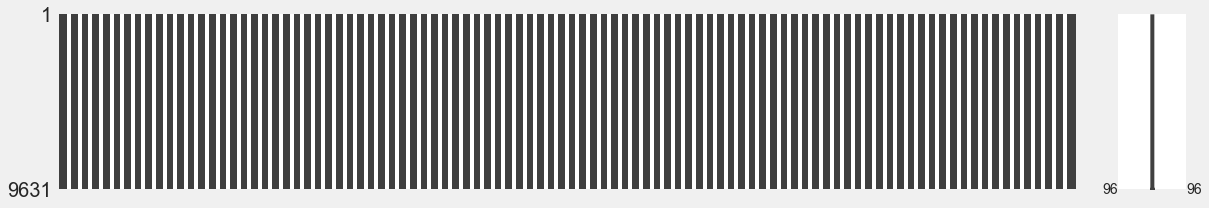

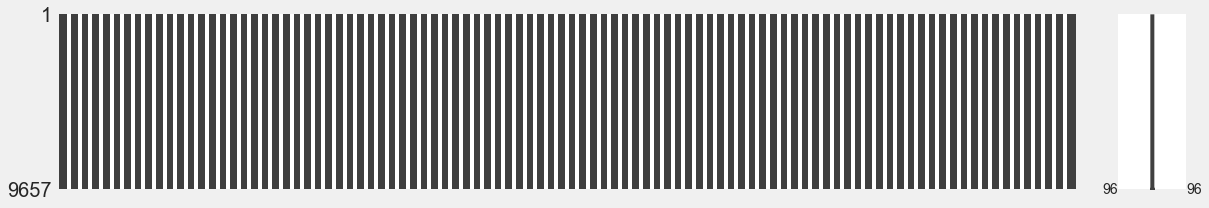

In [136]:
frames = [home, away]

for n in frames:
    print(n['HomeOrAway'].iloc[0])
    msno.matrix(n, figsize = (18, 3))

### 4. ```weather``` Dataframe
Using the split ```home``` and ```away``` dataframes, I'll add weather data

In [137]:
home = pd.merge(home,
                weather.drop('team_away_short', axis = 'columns').rename(columns = {'team_home_short':'Team'}),
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','Team']
)

away = pd.merge(away,
                weather.drop('team_home_short', axis = 'columns').rename(columns = {'team_away_short':'Team'}),
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','Team']
)

### 5. ```elevation``` Dataframe
Using the split ```home``` and ```away``` dataframes, I'll add elevation data. I need to replace the team names using a dictionary first

In [138]:
name_dict = {
    'Chargers' : 'LAC',
    'Cowboys' : 'DAL',
    'Panthers' : 'CAR',
    'Eagles' : 'PHI',
    'Patriots' : 'NE',
    'Vikings' : 'MIN',
    'Raiders' : 'LV',
    'Cardinals' : 'ARZ',
    'Saints' : 'NO',
    'Jaguars' : 'JAX',
    'Seahawks' : 'SEA',
    'Jets' : 'NYJ',
    'Buccaneers' : 'TB',
    'Bears' : 'CHI',
    'Dolphins' : 'MIA',
    'Browns' : 'CLV',
    'Ravens' : 'BLT',
    'Falcons' : 'ATL',
    'Packers' : 'GB',
    'Giants' : 'NYG',
    'Rams' : 'LAR',
    'Bengals' : 'CIN',
    'Broncos' : 'DEN',
    'Lions' : 'DET',
    'Redskins' : 'WAS',
    'Steelers' : 'PIT',
    'Titans' : 'TEN',
    'Texans' : 'HST',
    'Chiefs' : 'KC',
    'Colts' : 'IND',
    'Bills' : 'BUF',
    'Forty-Niners' : 'SF'
}

elevation = elevation.replace({'Team' : name_dict})

In [139]:
# home teams aren't displaced, and we'll treat the Mexico and England
# games as home nonetheless since there are so few 
home['elevation_displacement'] = 0

In [140]:
away

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,OpponentRZ,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail
0,201910115,16003,2019,1,KC,JAX,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,9.0,198.0,22.0,3.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,16,15,16990,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,JAX,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,365,1,93,3,SouthWest,0.00,0.0,0.48,Clear
1,201910119,19781,2019,1,BLT,MIA,AWAY,QB,OFF,1,1,20.0,17.0,324.0,85.0,16.2,19.1,5.0,0.0,158.33,83.0,1.0,1.0,3.0,6.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,19,16985,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,MIA,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,0,89,7,SouthEast,0.67,0.0,0.63,Humid and Mostly Cloudy
2,201910122,18857,2019,1,HST,NO,AWAY,QB,OFF,1,1,30.0,20.0,268.0,66.7,8.9,13.4,3.0,1.0,114.31,54.0,6.0,34.0,4.0,40.0,10.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,13,22,16997,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NO,36.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,0,72,0,No wind,0.55,0.0,0.60,DOME
3,201910108,17959,2019,1,TEN,CLV,AWAY,RB,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,84.0,4.4,1.0,18.0,2.0,1.0,75.0,75.0,1.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34,8,16984,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,CLE,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365,1,69,6,NorthEast,0.61,0.0,0.64,Mostly Cloudy
4,201910130,18881,2019,1,CIN,SEA,AWAY,WR,OFF,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,158.0,22.6,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,30,16992,2019_1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,SEA,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,365,3,66,4,South,0.96,0.0,0.76,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [141]:
elevation_displacement = []

for n in range(0,len(away)):
    elevation_displacement.append(
        (abs(
            int(
                elevation.loc[elevation['Team'] == away.iloc[n,4], 'elevation']) - int(elevation.loc[elevation['Team'] == away.iloc[n,5], 'elevation']))))

In [142]:
away['elevation_displacement'] = elevation_displacement

HOME
AWAY


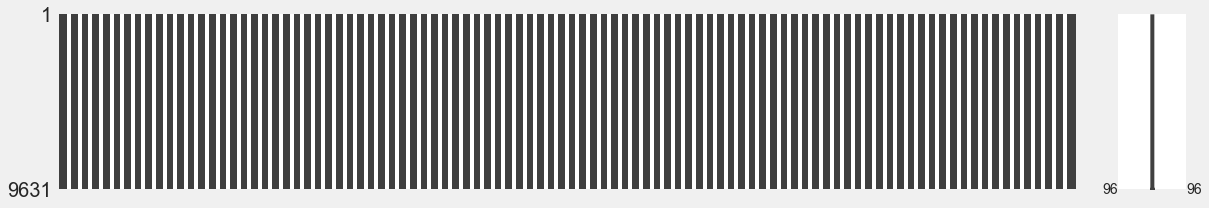

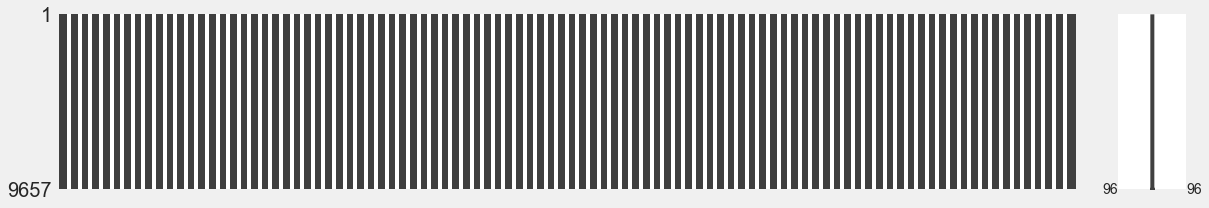

In [143]:
for n in frames:
    print(n['HomeOrAway'].iloc[0])
    msno.matrix(n, figsize = (18, 3))

### 6. Concatenating the ```home``` and ```away``` Dataframes

In [144]:
df = pd.concat([home,away], ignore_index = True)

<AxesSubplot:>

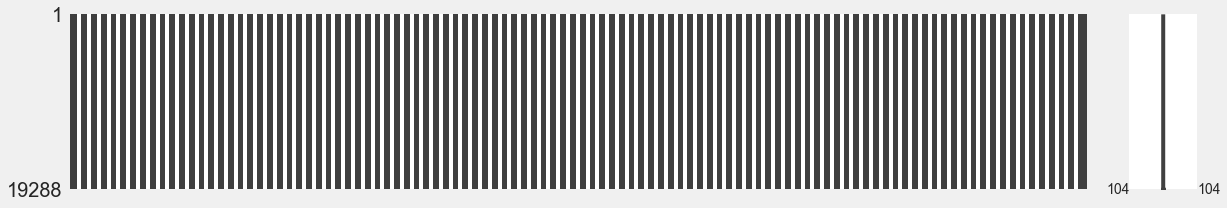

In [145]:
msno.matrix(df, figsize = (18,3))

### 7. Adding ```player_age``` to Dataframe

In [146]:
df = pd.merge(df,
              player_age,
              how = 'left',
              left_on = ['week_id','PlayerID'],
              right_on = ['week_id','PlayerID']
)

<AxesSubplot:>

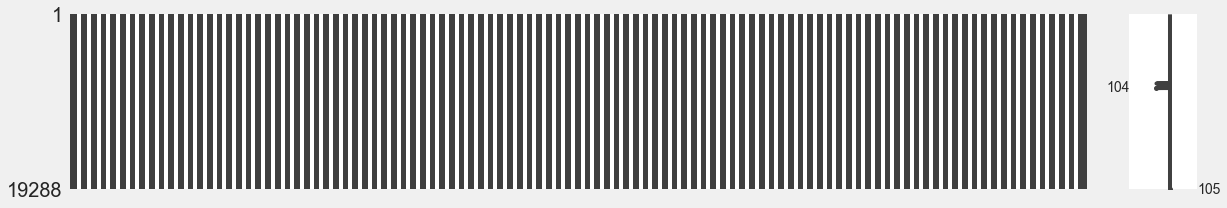

In [147]:
msno.matrix(df, figsize = (18,3))

In [148]:
df[df['age'].isna()]

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,OpponentRZ,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age
7626,202011419,20649,2020,14,MIA,KC,HOME,WR,OFF,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,19,16,17459,2020_14,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0,80,5,SouthEast,0.24,0.0,0.66,Clear,0,NaN
8126,202011622,17289,2020,16,NO,MIN,HOME,WR,OFF,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,22,20,17487,2020_16,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,72,0,No wind,0.00,0.0,0.28,DOME,0,NaN


In [149]:
df.at[8126,'age'] = 28.840257
df.at[7626,'age'] = df['age'].median()

<AxesSubplot:>

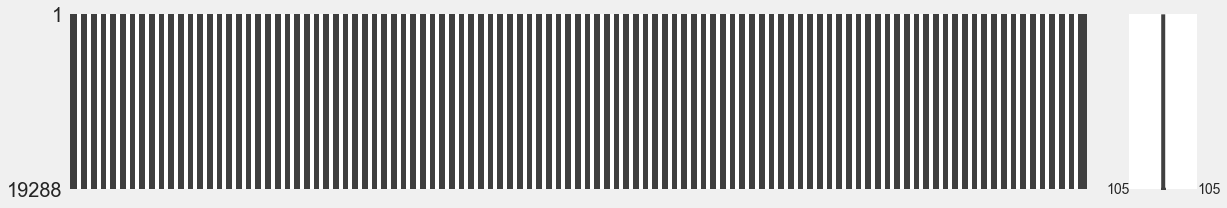

In [150]:
msno.matrix(df, figsize = (18,3))

In [113]:
# Saving this to create a checkpoint
df.to_csv('../../fixtures/cleaned_data/merged_df_without_stats_shifted.csv', index = False)

### 8. Shifting all stats columns 1 week
Select columns that are weekly stats columns

In [156]:
stat_cols = [
    'Played',
    'Started',
    'PassingAttempts',
    'PassingCompletions',
    'PassingYards',
    'PassingCompletionPercentage',
    'PassingYardsPerAttempt',
    'PassingYardsPerCompletion',
    'PassingTouchdowns',
    'PassingInterceptions',
    'PassingRating',
    'PassingLong',
    'PassingSacks',
    'PassingSackYards',
    'RushingAttempts',
    'RushingYards',
    'RushingYardsPerAttempt',
    'RushingTouchdowns',
    'RushingLong',
    'ReceivingTargets',
    'Receptions',
    'ReceivingYards',
    'ReceivingYardsPerReception',
    'ReceivingTouchdowns',
    'ReceivingLong',
    'Fumbles',
    'FumblesLost',
    'PuntReturns',
    'PuntReturnYards',
    'PuntReturnTouchdowns',
    'KickReturns',
    'KickReturnYards',
    'KickReturnTouchdowns',
    'SoloTackles',
    'AssistedTackles',
    'TacklesForLoss',
    'Sacks',
    'SackYards',
    'QuarterbackHits',
    'PassesDefended',
    'FumblesForced',
    'FumblesRecovered',
    'FumbleReturnTouchdowns',
    'Interceptions',
    'InterceptionReturnTouchdowns',
    'FieldGoalsAttempted',
    'FieldGoalsMade',
    'ExtraPointsMade',
    'TwoPointConversionPasses',
    'TwoPointConversionRuns',
    'TwoPointConversionReceptions',
    'ExtraPointsAttempted',
    'FieldGoalsMade0to19',
    'FieldGoalsMade20to29',
    'FieldGoalsMade30to39',
    'FieldGoalsMade40to49',
    'FieldGoalsMade50Plus',
    'PointsAllowedByDefenseSpecialTeams',
    'BlockedKickReturnTouchdowns',
    'PointsAllowed',
    'SpecialTeamsTouchdowns',
    'DefensiveTouchdowns',
    'BlockedKicks',
    'TwoPointConversionReturns',
    'FieldGoalReturnTouchdowns',
    'Safeties',
    'TouchdownsScored',
    'PassingYardsRZ',
    'PassingTouchdownsRZ',
    'PassingInterceptionsRZ',
    'RushingYardsRZ',
    'RushingTouchdownsRZ',
    'ReceptionsRZ',
    'ReceivingYardsRZ',
    'ReceivingTouchdownsRZ',
    'SacksRZ',
    'InterceptionsRZ',
    'FumblesForcedRZ',
    'FumlbesRecoveredRZ'
]

Peel out the non-stats columns into a separate list

In [157]:
other_cols = [item for item in list(df) if item not in list(stat_cols)]
other_cols

['GameKey',
 'PlayerID',
 'Season',
 'Week',
 'Team',
 'Opponent',
 'HomeOrAway',
 'Position',
 'PositionCategory',
 'InjuryStatus',
 'TeamID',
 'OpponentID',
 'ScoreID',
 'week_id',
 'OpponentRZ',
 'days_since_last_game',
 'absolute_hours_displaced',
 'weather_temperature',
 'weather_wind_mph_number',
 'weather_wind_direction',
 'weather_cloud_cover',
 'weather_precipitation',
 'weather_humidity',
 'weather_detail',
 'elevation_displacement',
 'age']

Create a new list that is ordered by non-stas columns, then stats columns. Then, find out which list position is the point at which non-stats and stats deviate

In [158]:
new_cols = other_cols + stat_cols
split_point = len(new_cols) - len(stat_cols)

if new_cols[split_point] != 'Played':
    print('Error')

Reorder the dataframe according to this list

In [160]:
df = df[new_cols]
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ
0,201910129,19562,2019,1,LAC,IND,HOME,RB,OFF,0,29,14,16991,2019_1,IND,365,0,73,6,South - SouthWest,0.40,0.0,0.67,Clear,0,24.314449,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,12.0,58.0,4.8,1.0,19.0,7.0,6.0,96.0,16.0,2.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,201910109,18055,2019,1,DAL,NYG,HOME,QB,OFF,0,9,23,16993,2019_1,NYG,365,0,72,0,No wind,0.80,0.0,0.28,DOME,0,26.113292,1,1,32.0,25.0,405.0,78.1,12.7,16.2,4.0,0.0,158.33,62.0,0.0,0.0,4.0,12.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201910105,18877,2019,1,CAR,LAR,HOME,RB,OFF,0,5,32,16989,2019_1,LAR,365,0,85,3,East,0.00,0.0,0.48,Clear,0,23.254527,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,19.0,128.0,6.7,2.0,23.0,11.0,10.0,81.0,8.1,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201910126,3943,2019,1,PHI,WAS,HOME,WR,OFF,0,26,35,16988,2019_1,WAS,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,32.771492,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,154.0,19.2,2.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201910121,4314,2019,1,NE,PIT,HOME,QB,OFF,0,21,28,16996,2019_1,PIT,365,0,64,3,NorthWest,0.35,0.0,0.66,Partly Cloudy,0,42.100378,1,1,36.0,24.0,341.0,66.7,9.5,14.2,3.0,0.0,124.88,58.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,

Split the dataframe into 2019 and 2020 dataframes, then add a new ```PlayerID_x``` column on which to sort the dataframes

In [161]:
# Prep the dataframes for stat_shifter
stats_2019 = df[df['Season'] == 2019]
stats_2020 = df[df['Season'] == 2020]

stats_2019['PlayerID_x'] = stats_2019['PlayerID']
stats_2020['PlayerID_x'] = stats_2020['PlayerID']

frames = [stats_2019, stats_2020]

<ipython-input-161-0c60ea5f03dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_2019['PlayerID_x'] = stats_2019['PlayerID']
<ipython-input-161-0c60ea5f03dd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_2020['PlayerID_x'] = stats_2020['PlayerID']


Set a new index, then sort by ```PlayerID``` and ```Week```

In [162]:
stats_2019 = stats_2019.set_index('PlayerID_x').sort_values(by = ['PlayerID','Week'], ascending = True)
stats_2020 = stats_2020.set_index('PlayerID_x').sort_values(by = ['PlayerID','Week'], ascending = True)

Create quality control dataframes to check against after I use ```stat_shifter```

In [163]:
quality_control_2019 = stats_2019[stats_2019['PlayerID'].isin([1,2,5])]
quality_control_2020 = stats_2020[stats_2020['PlayerID'].isin([1,2,5])]

Create a testing dataframe to run ```stat_shifter``` on prior to running the whole dataframe through it

In [165]:
tester_2019 = quality_control_2019

In [ ]:
def stat_shifter(dataframe):
    """
    Shifts previous week stats to help predict current week performance.
    Different from pandas shift, takes into account unique player ID.
    Dataframe needs to have stats columns as the last columns
    Input: dataframe with PlayerID and week columns
    """
    
    for n in range(0,len(dataframe)-1):
        # First iterate through all rows 
        
        
        
        # if the current row does not match either next or last, make the current row 0
        if (dataframe['PlayerID'].iloc[n] != dataframe['PlayerID'].iloc[n+1]) & (dataframe['PlayerID'].iloc[n] != dataframe['PlayerID'].iloc[n-1]):
            for x in range(27,dataframe.shape[1]):
                dataframe.iloc[n,x] = 0
        
        # if the current row matches the one before and after it, make the current row the previous row
        elif (dataframe['PlayerID'].iloc[n] == dataframe['PlayerID'].iloc[n+1]) & (dataframe['PlayerID'].iloc[n] == dataframe['PlayerID'].iloc[n-1]):
            for x in range(27,dataframe.shape[1]):
                dataframe.iloc[n,x] = dataframe.iloc[n-1,x]
                
        # if the current row doesn't match the next, but matches the last, make the current row the previous row
        elif (dataframe['PlayerID'].iloc[n] != dataframe['PlayerID'].iloc[n+1]) & (dataframe['PlayerID'].iloc[n] == dataframe['PlayerID'].iloc[n-1]):
            for x in range(27,dataframe.shape[1]):
                dataframe.iloc[n,x] = dataframe.iloc[n-1,x]
                
        else:
            for x in range(27,dataframe.shape[1]):
                new_df_name.iloc[n,x] = 0

    return new_df_name

In [411]:
new_column_names = []
for n in list(stats_2019):
    new_column_names.append('previous_week_' + n)

In [412]:
new_column_names

['previous_week_GameKey',
 'previous_week_PlayerID',
 'previous_week_SeasonType',
 'previous_week_Season',
 'previous_week_Week',
 'previous_week_Team',
 'previous_week_Opponent',
 'previous_week_HomeOrAway',
 'previous_week_Position',
 'previous_week_PositionCategory',
 'previous_week_InjuryStatus',
 'previous_week_TeamID',
 'previous_week_OpponentID',
 'previous_week_ScoreID',
 'previous_week_week_id',
 'previous_week_Date',
 'previous_week_days_since_last_game',
 'previous_week_absolute_hours_displaced',
 'previous_week_weather_temperature',
 'previous_week_weather_wind_mph_number',
 'previous_week_weather_wind_direction',
 'previous_week_weather_cloud_cover',
 'previous_week_weather_precipitation',
 'previous_week_weather_humidity',
 'previous_week_weather_detail',
 'previous_week_elevation_displacement',
 'previous_week_age',
 'previous_week_Played',
 'previous_week_Started',
 'previous_week_PassingAttempts',
 'previous_week_PassingCompletions',
 'previous_week_PassingYards',
 'pr

In [413]:
def stat_shifter(new_df_name, dataframe, my_new_column_names):
    """
    Shifts previous week stats to help predict current week performance.
    Different from pandas shift, takes into account unique player ID.
    Dataframe needs to have stats columns as the last columns
    Input: dataframe with PlayerID and week columns
    """
    new_df_name = pd.DataFrame(columns = my_new_column_names)
    new_df_name['previous_week_PlayerID'] = dataframe['PlayerID']
    
    for n in range(0,len(dataframe)-1):
        # if the current row matches the one before and after it, make the current row the previous row
        if (dataframe['PlayerID'].iloc[n] == dataframe['PlayerID'].iloc[n+1]) & (dataframe['PlayerID'].iloc[n] == dataframe['PlayerID'].iloc[n-1]):
            for x in range(27,dataframe.shape[1]):
                new_df_name.iloc[n,x] = dataframe.iloc[n-1,x]
        # if the current row doesn't match the next, but matches the last, make the current row the previous row
        elif (dataframe['PlayerID'].iloc[n] != dataframe['PlayerID'].iloc[n+1]) & (dataframe['PlayerID'].iloc[n] == dataframe['PlayerID'].iloc[n-1]):
            for x in range(27,dataframe.shape[1]):
                new_df_name.iloc[n,x] = dataframe.iloc[n-1,x]
        # if the current row does not match either next or last, make the current row 0
        elif (dataframe['PlayerID'].iloc[n] != dataframe['PlayerID'].iloc[n+1]) & (dataframe['PlayerID'].iloc[n] != dataframe['PlayerID'].iloc[n-1]):
            for x in range(27,dataframe.shape[1]):
                new_df_name.iloc[n,x] = 0
        else:
            for x in range(27,dataframe.shape[1]):
                new_df_name.iloc[n,x] = 0

    return new_df_name

In [414]:
new_stats_2019 = stat_shifter('new_stats_2019', stats_2019, new_column_names)

In [418]:
new_stats_2020 = stat_shifter('new_stats_2019', stats_2020, new_column_names)

In [419]:
stats_2020[['PlayerID','PointsAllowedByDefenseSpecialTeams']][stats_2020['PlayerID'].isin([1, 2])]

,PlayerID,PointsAllowedByDefenseSpecialTeams
PlayerID_x,,
1,1,20.0
1,1,15.0
1,1,26.0
1,1,31.0
1,1,10.0
1,1,10.0
1,1,34.0
1,1,28.0
1,1,30.0


In [420]:
new_stats_2020[['previous_week_PlayerID','previous_week_PointsAllowedByDefenseSpecialTeams']][new_stats_2020['previous_week_PlayerID'].isin([1, 2])]

,previous_week_PlayerID,previous_week_PointsAllowedByDefenseSpecialTeams
PlayerID_x,,
1,1,0
1,1,20
1,1,15
1,1,26
1,1,31
1,1,10
1,1,10
1,1,34
1,1,28


In [426]:
stats_2019 = stats_2019.join(new_stats_2019[list(new_stats_2019)[27:len(new_stats_2019)]])

In [439]:
list(stats_2020)[27:93]

['Played',
 'Started',
 'PassingAttempts',
 'PassingCompletions',
 'PassingYards',
 'PassingCompletionPercentage',
 'PassingYardsPerAttempt',
 'PassingYardsPerCompletion',
 'PassingTouchdowns',
 'PassingInterceptions',
 'PassingRating',
 'PassingLong',
 'PassingSacks',
 'PassingSackYards',
 'RushingAttempts',
 'RushingYards',
 'RushingYardsPerAttempt',
 'RushingTouchdowns',
 'RushingLong',
 'ReceivingTargets',
 'Receptions',
 'ReceivingYards',
 'ReceivingYardsPerReception',
 'ReceivingTouchdowns',
 'ReceivingLong',
 'Fumbles',
 'FumblesLost',
 'PuntReturns',
 'PuntReturnYards',
 'PuntReturnTouchdowns',
 'KickReturns',
 'KickReturnYards',
 'KickReturnTouchdowns',
 'SoloTackles',
 'AssistedTackles',
 'TacklesForLoss',
 'Sacks',
 'SackYards',
 'QuarterbackHits',
 'PassesDefended',
 'FumblesForced',
 'FumblesRecovered',
 'FumbleReturnTouchdowns',
 'Interceptions',
 'InterceptionReturnTouchdowns',
 'FieldGoalsAttempted',
 'FieldGoalsMade',
 'ExtraPointsMade',
 'TwoPointConversionPasses',
 '

In [436]:
list(stats_2019)[93]

'PointsAllowedByDefenseSpecialTeams'

In [447]:
stats_2019 = stats_2019.drop(list(stats_2019)[27:94], axis = 'columns').reset_index(drop = True).drop_duplicates()

In [448]:
stats_2020 = stats_2020.drop(list(stats_2020)[27:94], axis = 'columns').reset_index(drop = True).drop_duplicates()

In [450]:
df = pd.concat([stats_2019,stats_2020], axis = 'rows')

In [451]:
df.drop_duplicates()

,GameKey,PlayerID,SeasonType,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,Date,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,previous_week_Played,previous_week_Started,previous_week_PassingAttempts,previous_week_PassingCompletions,previous_week_PassingYards,previous_week_PassingCompletionPercentage,previous_week_PassingYardsPerAttempt,previous_week_PassingYardsPerCompletion,previous_week_PassingTouchdowns,previous_week_PassingInterceptions,previous_week_PassingRating,previous_week_PassingLong,previous_week_PassingSacks,previous_week_PassingSackYards,previous_week_RushingAttempts,previous_week_RushingYards,previous_week_RushingYardsPerAttempt,previous_week_RushingTouchdowns,previous_week_RushingLong,previous_week_ReceivingTargets,previous_week_Receptions,previous_week_ReceivingYards,previous_week_ReceivingYardsPerReception,previous_week_ReceivingTouchdowns,previous_week_ReceivingLong,previous_week_Fumbles,previous_week_FumblesLost,previous_week_PuntReturns,previous_week_PuntReturnYards,previous_week_PuntReturnTouchdowns,previous_week_KickReturns,previous_week_KickReturnYards,previous_week_KickReturnTouchdowns,previous_week_SoloTackles,previous_week_AssistedTackles,previous_week_TacklesForLoss,previous_week_Sacks,previous_week_SackYards,previous_week_QuarterbackHits,previous_week_PassesDefended,previous_week_FumblesForced,previous_week_FumblesRecovered,previous_week_FumbleReturnTouchdowns,previous_week_Interceptions,previous_week_InterceptionReturnTouchdowns,previous_week_FieldGoalsAttempted,previous_week_FieldGoalsMade,previous_week_ExtraPointsMade,previous_week_TwoPointConversionPasses,previous_week_TwoPointConversionRuns,previous_week_TwoPointConversionReceptions,previous_week_ExtraPointsAttempted,previous_week_FieldGoalsMade0to19,previous_week_FieldGoalsMade20to29,previous_week_FieldGoalsMade30to39,previous_week_FieldGoalsMade40to49,previous_week_FieldGoalsMade50Plus,previous_week_Safeties,previous_week_TwoPointConversionReturns,previous_week_BlockedKicks,previous_week_FieldGoalReturnTouchdowns,previous_week_BlockedKickReturnTouchdowns,previous_week_DefensiveTouchdowns,previous_week_PointsAllowed,previous_week_TouchdownsScored,previous_week_SpecialTeamsTouchdowns,previous_week_PointsAllowedByDefenseSpecialTeams
0,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,24,11,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,27
2,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.5,2,14,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,23
3,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,21,4,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,0,0,38
4,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,15,7,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [452]:
target

,week_id,PlayerID,performance,performance_class
0,2018_1,2,1,far overperformed
1,2018_1,26,1,far overperformed
2,2018_1,37,0,far underperformed
3,2018_1,36,1,far overperformed
4,2018_1,28,1,far overperformed
...,...,...,...,...
28830,2020_17,16191,0,None
28831,2020_17,17118,0,None
28832,2020_17,21105,0,overperformed
28833,2020_17,21203,1,overperformed


In [455]:
df = df.fillna(0)

In [458]:
tester_df = pd.merge(df,
                     target[['week_id','PlayerID','performance']],
                     how = 'left',
                     left_on = ['week_id','PlayerID'],
                     right_on = ['week_id','PlayerID']
                    )

<AxesSubplot:>

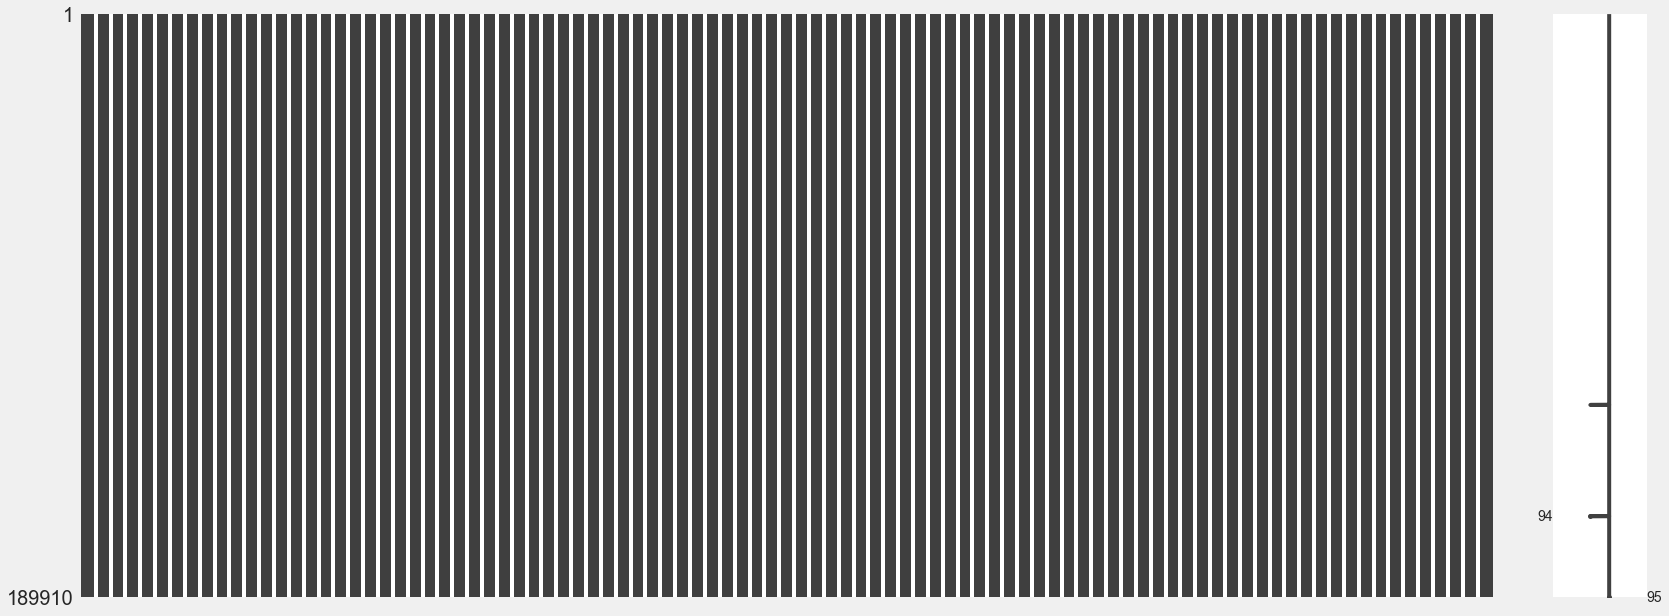

In [459]:
msno.matrix(tester_df)

In [461]:
df = tester_df

In [466]:
df.to_csv('../../fixtures/cleaned_data/merged_df_without_stats_shifted.csv', index = False)

In [460]:
tester_df

,GameKey,PlayerID,SeasonType,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,Date,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,previous_week_Played,previous_week_Started,previous_week_PassingAttempts,previous_week_PassingCompletions,previous_week_PassingYards,previous_week_PassingCompletionPercentage,previous_week_PassingYardsPerAttempt,previous_week_PassingYardsPerCompletion,previous_week_PassingTouchdowns,previous_week_PassingInterceptions,previous_week_PassingRating,previous_week_PassingLong,previous_week_PassingSacks,previous_week_PassingSackYards,previous_week_RushingAttempts,previous_week_RushingYards,previous_week_RushingYardsPerAttempt,previous_week_RushingTouchdowns,previous_week_RushingLong,previous_week_ReceivingTargets,previous_week_Receptions,previous_week_ReceivingYards,previous_week_ReceivingYardsPerReception,previous_week_ReceivingTouchdowns,previous_week_ReceivingLong,previous_week_Fumbles,previous_week_FumblesLost,previous_week_PuntReturns,previous_week_PuntReturnYards,previous_week_PuntReturnTouchdowns,previous_week_KickReturns,previous_week_KickReturnYards,previous_week_KickReturnTouchdowns,previous_week_SoloTackles,previous_week_AssistedTackles,previous_week_TacklesForLoss,previous_week_Sacks,previous_week_SackYards,previous_week_QuarterbackHits,previous_week_PassesDefended,previous_week_FumblesForced,previous_week_FumblesRecovered,previous_week_FumbleReturnTouchdowns,previous_week_Interceptions,previous_week_InterceptionReturnTouchdowns,previous_week_FieldGoalsAttempted,previous_week_FieldGoalsMade,previous_week_ExtraPointsMade,previous_week_TwoPointConversionPasses,previous_week_TwoPointConversionRuns,previous_week_TwoPointConversionReceptions,previous_week_ExtraPointsAttempted,previous_week_FieldGoalsMade0to19,previous_week_FieldGoalsMade20to29,previous_week_FieldGoalsMade30to39,previous_week_FieldGoalsMade40to49,previous_week_FieldGoalsMade50Plus,previous_week_Safeties,previous_week_TwoPointConversionReturns,previous_week_BlockedKicks,previous_week_FieldGoalReturnTouchdowns,previous_week_BlockedKickReturnTouchdowns,previous_week_DefensiveTouchdowns,previous_week_PointsAllowed,previous_week_TouchdownsScored,previous_week_SpecialTeamsTouchdowns,previous_week_PointsAllowedByDefenseSpecialTeams,performance
0,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
1,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,24.0,11.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0,27.0,1.0
2,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,2.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0,23.0,1.0
3,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,

In [429]:
stats_2020

,GameKey,PlayerID,SeasonType,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,Date,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,Safeties,TwoPointConversionReturns,BlockedKicks,FieldGoalReturnTouchdowns,BlockedKickReturnTouchdowns,DefensiveTouchdowns,PointsAllowed,TouchdownsScored,SpecialTeamsTouchdowns,PointsAllowedByDefenseSpecialTeams,previous_week_Played,previous_week_Started,previous_week_PassingAttempts,previous_week_PassingCompletions,previous_week_PassingYards,previous_week_PassingCompletionPercentage,previous_week_PassingYardsPerAttempt,previous_week_PassingYardsPerCompletion,previous_week_PassingTouchdowns,previous_week_PassingInterceptions,previous_week_PassingRating,previous_week_PassingLong,previous_week_PassingSacks,previous_week_PassingSackYards,previous_week_RushingAttempts,previous_week_RushingYards,previous_week_RushingYardsPerAttempt,previous_week_RushingTouchdowns,previous_week_RushingLong,previous_week_ReceivingTargets,previous_week_Receptions,previous_week_ReceivingYards,previous_week_ReceivingYardsPerReception,previous_week_ReceivingTouchdowns,previous_week_ReceivingLong,previous_week_Fumbles,previous_week_FumblesLost,previous_week_PuntReturns,previous_week_PuntReturnYards,previous_week_PuntReturnTouchdowns,previous_week_KickReturns,previous_week_KickReturnYards,previous_week_KickReturnTouchdowns,previous_week_SoloTackles,previous_week_AssistedTackles,previous_week_TacklesForLoss,previous_week_Sacks,previous_week_SackYards,previous_week_QuarterbackHits,previous_week_PassesDefended,previous_week_FumblesForced,previous_week_FumblesRecovered,previous_week_FumbleReturnTouchdowns,previous_week_Interceptions,previous_week_InterceptionReturnTouchdowns,previous_week_FieldGoalsAttempted,previous_week_FieldGoalsMade,previous_week_ExtraPointsMade,previous_week_TwoPointConversionPasses,previous_week_TwoPointConversionRuns,previous_week_TwoPointConversionReceptions,previous_week_ExtraPointsAttempted,previous_week_FieldGoalsMade0to19,previous_week_FieldGoalsMade20to29,previous_week_FieldGoalsMade30to39,previous_week_FieldGoalsMade40to49,previous_week_FieldGoalsMade50Plus,previous_week_Safeties,previous_week_TwoPointConversionReturns,previous_week_BlockedKicks,previous_week_FieldGoalReturnTouchdowns,previous_week_BlockedKickReturnTouchdowns,previous_week_DefensiveTouchdowns,previous_week_PointsAllowed,previous_week_TouchdownsScored,previous_week_SpecialTeamsTouchdowns,previous_week_PointsAllowedByDefenseSpecialTeams
PlayerID_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,202010131,1,1,2020,1,ARZ,SF,AWAY,DEF,DEF,0,1,31,17275,2020_1,2020-09-13T16:25:00,259.0,1,71,6,NorthWest,0.17,0.0,0.61,Clear,3180474,25.354502,1,1,0.0,

In [ ]:
df = pd.concat([df,df_add], axis=1)
new_stats_2019[list(new_stats_2019)[27:len(new_stats_2019)]]

In [422]:
list(new_stats_2019)[27:len(new_stats_2019)]

['previous_week_Played',
 'previous_week_Started',
 'previous_week_PassingAttempts',
 'previous_week_PassingCompletions',
 'previous_week_PassingYards',
 'previous_week_PassingCompletionPercentage',
 'previous_week_PassingYardsPerAttempt',
 'previous_week_PassingYardsPerCompletion',
 'previous_week_PassingTouchdowns',
 'previous_week_PassingInterceptions',
 'previous_week_PassingRating',
 'previous_week_PassingLong',
 'previous_week_PassingSacks',
 'previous_week_PassingSackYards',
 'previous_week_RushingAttempts',
 'previous_week_RushingYards',
 'previous_week_RushingYardsPerAttempt',
 'previous_week_RushingTouchdowns',
 'previous_week_RushingLong',
 'previous_week_ReceivingTargets',
 'previous_week_Receptions',
 'previous_week_ReceivingYards',
 'previous_week_ReceivingYardsPerReception',
 'previous_week_ReceivingTouchdowns',
 'previous_week_ReceivingLong',
 'previous_week_Fumbles',
 'previous_week_FumblesLost',
 'previous_week_PuntReturns',
 'previous_week_PuntReturnYards',
 'previou

In [ ]:
stats_2019

In [ ]:
quality_control_2019[['PlayerID','Week','Season','PointsAllowedByDefenseSpecialTeams']]

In [213]:
stats_2019[['PlayerID','Week','Season','QuarterbackHits']]

,PlayerID,Week,Season,QuarterbackHits
PlayerID_x,,,,
1,1,1,2019,4.0
1,1,2,2019,7.0
1,1,3,2019,3.0
1,1,4,2019,8.0
1,1,5,2019,13.0
...,...,...,...,...
21636,21636,6,2019,0.0
21636,21636,7,2019,0.0
21636,21636,8,2019,0.0


In [210]:
quality_control_2019

,GameKey,PlayerID,SeasonType,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,Date,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,Safeties,TwoPointConversionReturns,BlockedKicks,FieldGoalReturnTouchdowns,BlockedKickReturnTouchdowns,DefensiveTouchdowns,PointsAllowed,TouchdownsScored,SpecialTeamsTouchdowns,PointsAllowedByDefenseSpecialTeams
PlayerID_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,24.0,11.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0,27.0
1,201910203,1,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,2019-09-15T13:00:00,7.0,2,81,3,North - NorthWest,0.00,0.0,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,2.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0,23.0
1,201910301,1,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,2019-09-22T16:05:00,7.0,0,72,0,No wind,0.40,0.0,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0,38.0
1,201910401,1,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,2019-09-29T16:05:00,7.0,0,72,0,No wind,0.38,0.0,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0,21.0
1,201910507,1,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,2019-10-06T13:00:00,7.0,2,76,6,West - SouthWest,0.87,0.0,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0,23.0
1,201910601,1,1,2019,6,ARZ,ATL,HOME,DEF,DEF,0,1,2,17070,2019_6,2019-10-13T16:05:00,7.0,0,72,0,No wind,0.00,0.0,0.13,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,15.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [211]:
stats_2019[stats_2019['PlayerID'] == 1]

,GameKey,PlayerID,SeasonType,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,Date,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,Safeties,TwoPointConversionReturns,BlockedKicks,FieldGoalReturnTouchdowns,BlockedKickReturnTouchdowns,DefensiveTouchdowns,PointsAllowed,TouchdownsScored,SpecialTeamsTouchdowns,PointsAllowedByDefenseSpecialTeams
PlayerID_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0,38.0
1,201910203,1,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,2019-09-15T13:00:00,7.0,2,81,3,North - NorthWest,0.00,0.0,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0,21.0
1,201910301,1,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,2019-09-22T16:05:00,7.0,0,72,0,No wind,0.40,0.0,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0,23.0
1,201910401,1,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,2019-09-29T16:05:00,7.0,0,72,0,No wind,0.38,0.0,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,15.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0,33.0
1,201910507,1,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,2019-10-06T13:00:00,7.0,2,76,6,West - SouthWest,0.87,0.0,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,67.0,13.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0,21.0
1,201910601,1,1,2019,6,ARZ,ATL,HOME,DEF,DEF,0,1,2,17070,2019_6,2019-10-13T16:05:00,7.0,0,72,0,No wind,0.00,0.0,0.13,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0

In [209]:
stat_shifter(stats_2019)

,GameKey,PlayerID,SeasonType,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,Date,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,Safeties,TwoPointConversionReturns,BlockedKicks,FieldGoalReturnTouchdowns,BlockedKickReturnTouchdowns,DefensiveTouchdowns,PointsAllowed,TouchdownsScored,SpecialTeamsTouchdowns,PointsAllowedByDefenseSpecialTeams
PlayerID_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,201910101,1,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,2019-09-08T16:25:00,365.0,0,72,0,No wind,0.39,0.00,0.32,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0,38.0
1,201910203,1,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,2019-09-15T13:00:00,7.0,2,81,3,North - NorthWest,0.00,0.00,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0,21.0
1,201910301,1,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,2019-09-22T16:05:00,7.0,0,72,0,No wind,0.40,0.00,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0,23.0
1,201910401,1,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,2019-09-29T16:05:00,7.0,0,72,0,No wind,0.38,0.00,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,15.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0,33.0
1,201910507,1,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,2019-10-06T13:00:00,7.0,2,76,6,West - SouthWest,0.87,0.00,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,8.0,67.0,13.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
for n in frames:
    n = stat_shifter(n)

In [ ]:
stats_2019['week_id'] = stats_2019['Season'].astype(str) + "_" + stats_2019['new_week_id_list'].astype(str)
stats_2020['week_id'] = stats_2020['Season'].astype(str) + "_" + stats_2020['new_week_id_list'].astype(str)

In [ ]:
stats_2019 = stats_2019.reset_index(drop = True)
stats_2020 = stats_2020.reset_index(drop = True)

In [ ]:
stats_2020.loc[15295, 'week_id'] = '2020_15'
stats_2020.loc[15294, 'week_id'] = '2020_16'

In [ ]:
stats_2019 = stats_2019.drop('new_week_id_list', axis = 'columns')
stats_2020 = stats_2020.drop('new_week_id_list', axis = 'columns')
stats_2019 = stats_2019.drop('PlayerID_x', axis = 'columns')
stats_2020 = stats_2020.drop('PlayerID_x', axis = 'columns')

In [ ]:
stats_2019.append(stats_2020)

In [ ]:
stats = stats_2019

In [ ]:
msno.matrix(stats)

In [ ]:
stats

In [ ]:
stats[(stats['PlayerID'] == 21542) & (stats['week_id'] == '2019_17')]

In [ ]:
print(stats.shape[0])
print(df.shape[0])

In [ ]:
df[(df['PlayerID'] == 21542) & (df['week_id'] == '2019_17')]

In [ ]:
list(df)

In [ ]:
# I need to bring in the stats column prior to the hours_displaced
# table so that I can split it into home and away dataframes to make
# merging smoother, so I'll do that next. Just in case I have the same
# issue with the stats Team column having different names, I'll start
# by applying the dictionary I applied before
# I'll also fill in the missing week_id instances before merging
# I'll also add the defense values

#stats = stats.replace({'Team':defense_abbrev_dict})
#stats['week_id'] = stats['Season'].astype(str) + "_" + stats['Week'].astype(str)

df = pd.merge(df,
              stats.drop('Team', axis = 'columns'),
              how = 'right',
              left_on = ['PlayerID','week_id'],
              right_on = ['PlayerID','week_id']
)

msno.matrix(df, figsize=(18,6))

In [ ]:
# Start the merge with player team, merging it with the positions
# datframe on PlayerID and dropping duplicates. I'll also check for
# missing values with a missingno matrix
df = df.merge(positions, how = 'left', on = 'PlayerID').drop_duplicates()
msno.matrix(df, figsize=(18,2))

In [ ]:
df = df.merge(player_team, how = 'left', on = 'PlayerID').drop_duplicates()
msno.matrix(df, figsize=(18,2))

In [ ]:
# Looks like the first 25% of the days_since_last_game data is null
# Some tables contain 2018 - 2020 data, others do not.
# days_since_last_game does not contain 2018 data, so this is a good
# time to cut 2018 from the dataframe

season_year = []

for n in df['week_id']:
    season_year.append(n[:4])
    
df['season_year'] = season_year

df = df[df['season_year'] != '2018']

msno.matrix(df, figsize=(18,6))

In [ ]:
df = df.rename(columns = {'week_id':'stats_week_id'})

In [ ]:
df['week_id'] = df['Season'].astype(str) + "_" + df['Week'].astype(str)

In [ ]:
df

In [ ]:
df[df['SeasonType'].notnull()]

In [ ]:
list(df)

In [ ]:
null_df = df[df.isna().any(axis=1)]
null_df

In [ ]:
df = pd.merge(df,
              defense[[
                 'PlayerID',
                 'week_id',
                 'BlockedKicks',
                 'DefensiveTouchdowns',
                 'BlockedKickReturnTouchdowns',
                 'SpecialTeamsTouchdowns',
                 'FieldGoalReturnTouchdowns',
                 'PointsAllowed',
                 'Safeties',
                 'TouchdownsScored',
                 'TwoPointConversionReturns',
                 'PointsAllowedByDefenseSpecialTeams'
              ]],
              how = 'left',
              left_on = ['PlayerID','week_id'],
              right_on = ['PlayerID','week_id']
)

msno.matrix(df, figsize=(18,2))

#### Bringing in the `hours_displaced` data

In [ ]:
home_away_df = stats[['Season','Week','HomeOrAway','Team','Opponent']]

In [ ]:
home_away_df['week_id'] = home_away_df['Season'].astype(str) + "_" + home_away_df['Week'].astype(str)

In [ ]:
home_away_df

In [ ]:
df

In [ ]:
df = df.drop(['Team_x','Position_x'],axis = 'columns')

In [ ]:
msno.matrix(df)

In [ ]:
df

In [ ]:
df = pd.merge(df,
              injury_status,
              how = 'left',
              left_on = ['PlayerID','week_id'],
              right_on = ['PlayerID','week_id']
)

print(f'There are {df.injury_status.nunique()} unique values in this column: {df.injury_status.unique()}')
msno.matrix(df, figsize=(18,2))

In [ ]:
list(df)

In [ ]:
df = pd.merge(df,
              home_away_df,
              how = 'left',
              left_on = ['week_id','Team'],
              right_on = ['week_id','Team']
)

msno.matrix(df, figsize=(18,2))

In [ ]:
df['absolute_hours_displaced'].fillna(0)

In [ ]:
df[df['absolute_hours_displaced'].isna()]

In [ ]:
df = df['absolute_hours_displaced'].fillna(0)

In [ ]:
home = df[df['HomeOrAway'] == 'HOME']
away = df[df['HomeOrAway'] == 'AWAY']

In [ ]:
home = pd.merge(home,
                weather,
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','team_home_short']
)

away = pd.merge(away,
                weather,
                how = 'left',
                left_on = ['week_id','Team'],
                right_on = ['week_id','team_away_short']
)

In [ ]:
df = pd.merge(df,
              target,
              how = 'left',
              left_on = ['week_id','PlayerID'],
              right_on = ['week_id','PlayerID']
)

In [ ]:
df = pd.concat([home,away], ignore_index = True).drop(['team_home_short_y','team_away_short_y','team_away_short_x','team_home_short_x'], axis = 1)

In [ ]:
df = df.drop_duplicates()

In [ ]:
season_week = []

for n in df['week_id']:
    season_week.append(n[5:])
    
df['season_week'] = season_week

### Understanding the data
<a id='data_review_cell'></a>

In [ ]:
df[df['weather_temperature'].isnull()]

In [ ]:
weather[weather['team_home_short'] == 'SF']

In [ ]:
# Find out basic characteristics of the columns and, if necessary, drop columns with null values
df.info()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.describe()

### Preparing the data
<a id='preparing_data_cell'></a>

In [ ]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop('performance', axis = 1)
y = df['performance']

In [ ]:
labels = target['performance_class'].unique()
labels

In [ ]:
target = target[target['performance_class'] != None]

In [ ]:
target = target['performance_class']

In [ ]:
y

In [ ]:
visualizer = ClassBalance(labels=['far overperformed', 'far underperformed', 'overperformed',
       'underperformed'])

visualizer.fit(target) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [ ]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=['Overperform', 'Underperform'])

visualizer.fit(y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

## Global Machine Learning Model
<a id='global_model_cell'></a>
Explain concept

### Model Selection
<a id='model_selection_cell'></a>

#### Selecting Columns 
<a id='column_selection_cell'></a>
From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html):
> Create a callable to select columns to be used with ColumnTransformer.   
>   
>```make_column_selector``` can select columns based on datatype or the columns name with a regex. When using multiple selection criteria, all criteria must match for a column to be selected.

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

#### Selecting models to score
<a id='model_scoring_selection_cell'></a>

In [ ]:
# list of models to use
models = [
    SVC(gamma='auto'),
    NuSVC(gamma='auto'),
    LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3),
    KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'),
    LogisticRegressionCV(cv=3, max_iter=100),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

In [ ]:
# function to score models
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    Input: 
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [ ]:
# function to visualize models
def visualize_model(X, y, estimator, **kwargs):
    """
    
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Underperformed', 'Overperformed'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [ ]:
X['Positionsition'].unique()

In [ ]:
y.count()

#### Scoring selected models
<a id='scoring_models_cell'></a>

In [ ]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

In [ ]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in models:
    score_model(X_train, y_train, model)
    visualize_model(X_test, y_test, model)

## Hyperparameter Tuning
<a id='hyperparameter_tuning_cell'></a>

## Title
<a id='header_cell'></a>